In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# Final model for 180 dataset

In [16]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [17]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [18]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [19]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [20]:
model_180 = FetchModel("space_miss").compile()

In [21]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_180'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_180 = model_180.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_180 = az.from_cmdstanpy(fit_180)

03:51:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:10 - cmdstanpy - INFO - CmdStan done processing.
03:56:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
	Exception: cholesky_decompose: A is not 

In [22]:
post_pred = PostPred(posterior_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

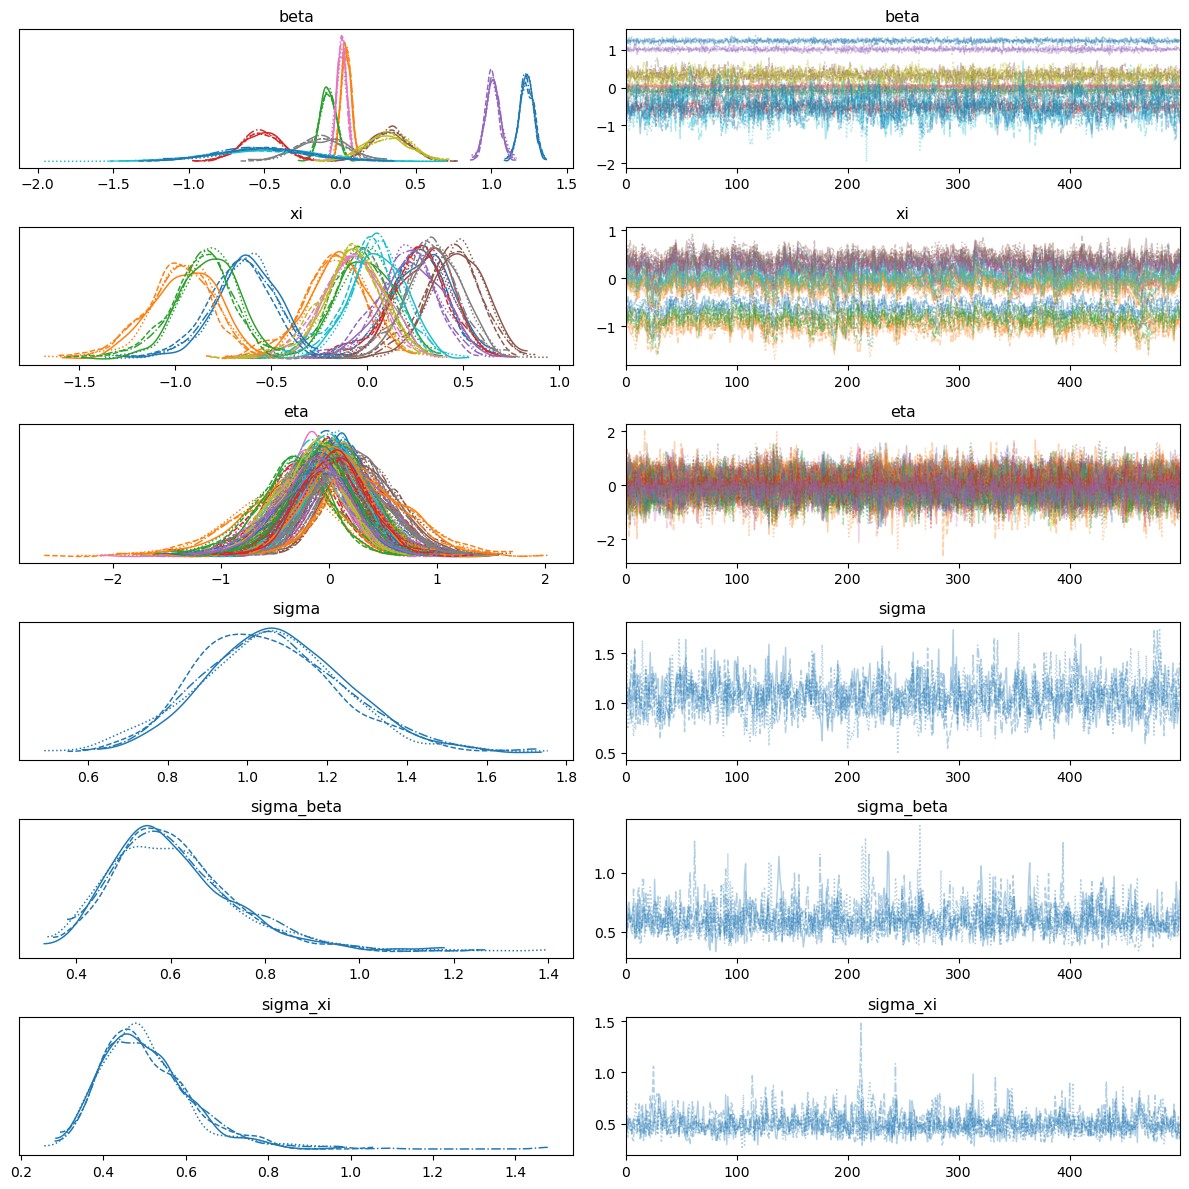

In [23]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [24]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2753.47    72.21
p_waic      107.33        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2754.38    72.25
p_loo      108.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2660   99.8%
 (0.5, 0.7]   (ok)          5    0.2%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [25]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [26]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   2   74  125  150  160  187  193  233  365  372  384  402  403  441
  474  475  529  579  602  656  675  676  778  798  851  867  872  873
  907 1093 1122 1156 1157 1262 1337 1366 1394 1427 1524 1532 1539 1568
 1618 1619 1647 1658 1674 1748 1780 1813 1821 1832 1878 1935 1973 2095
 2110 2127 2135 2158 2224 2240 2331 2338 2350 2371 2377 2384 2389 2440
 2449 2492 2518 2532 2552 2561 2562 2569 2646 2650 2672 2691 2705 2725
 2738 2750 2769 2808 2817 2851 2877 2879 2911 2997 3030 3044 3087 3220
 3222 3226 3227 3252 3267 3272 3330 3400 3401 3443 3496 3507 3560 3610
 3611 3626 3663 3743 3770]

The total number of outliers is: 117

The MSE is: 2.2136948529411766

The MAE is: 0.7188813025210085

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9561140285071268



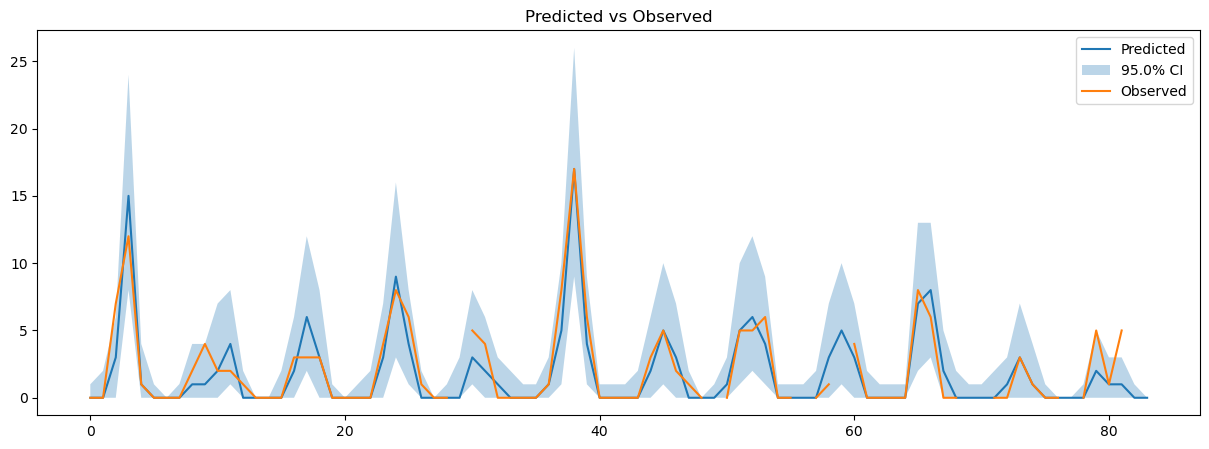

In [27]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

# Final model for 120 dataset

In [28]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [29]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [30]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [31]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [32]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(Y['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[idx_obs])
dummy_july_miss = pd.Series(dummy_july[idx_miss])


In [35]:
model_120 = FetchModel("space_dummy_rej").compile()

03:59:36 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_dummy_rej.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_dummy_rej.exe
04:00:55 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_dummy_rej.exe


In [36]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss
}

fit_120 = model_120.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120 = az.from_cmdstanpy(fit_120)

04:00:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:03 - cmdstanpy - INFO - CmdStan done processing.
04:11:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_de

In [37]:
post_pred = PostPred(posterior_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

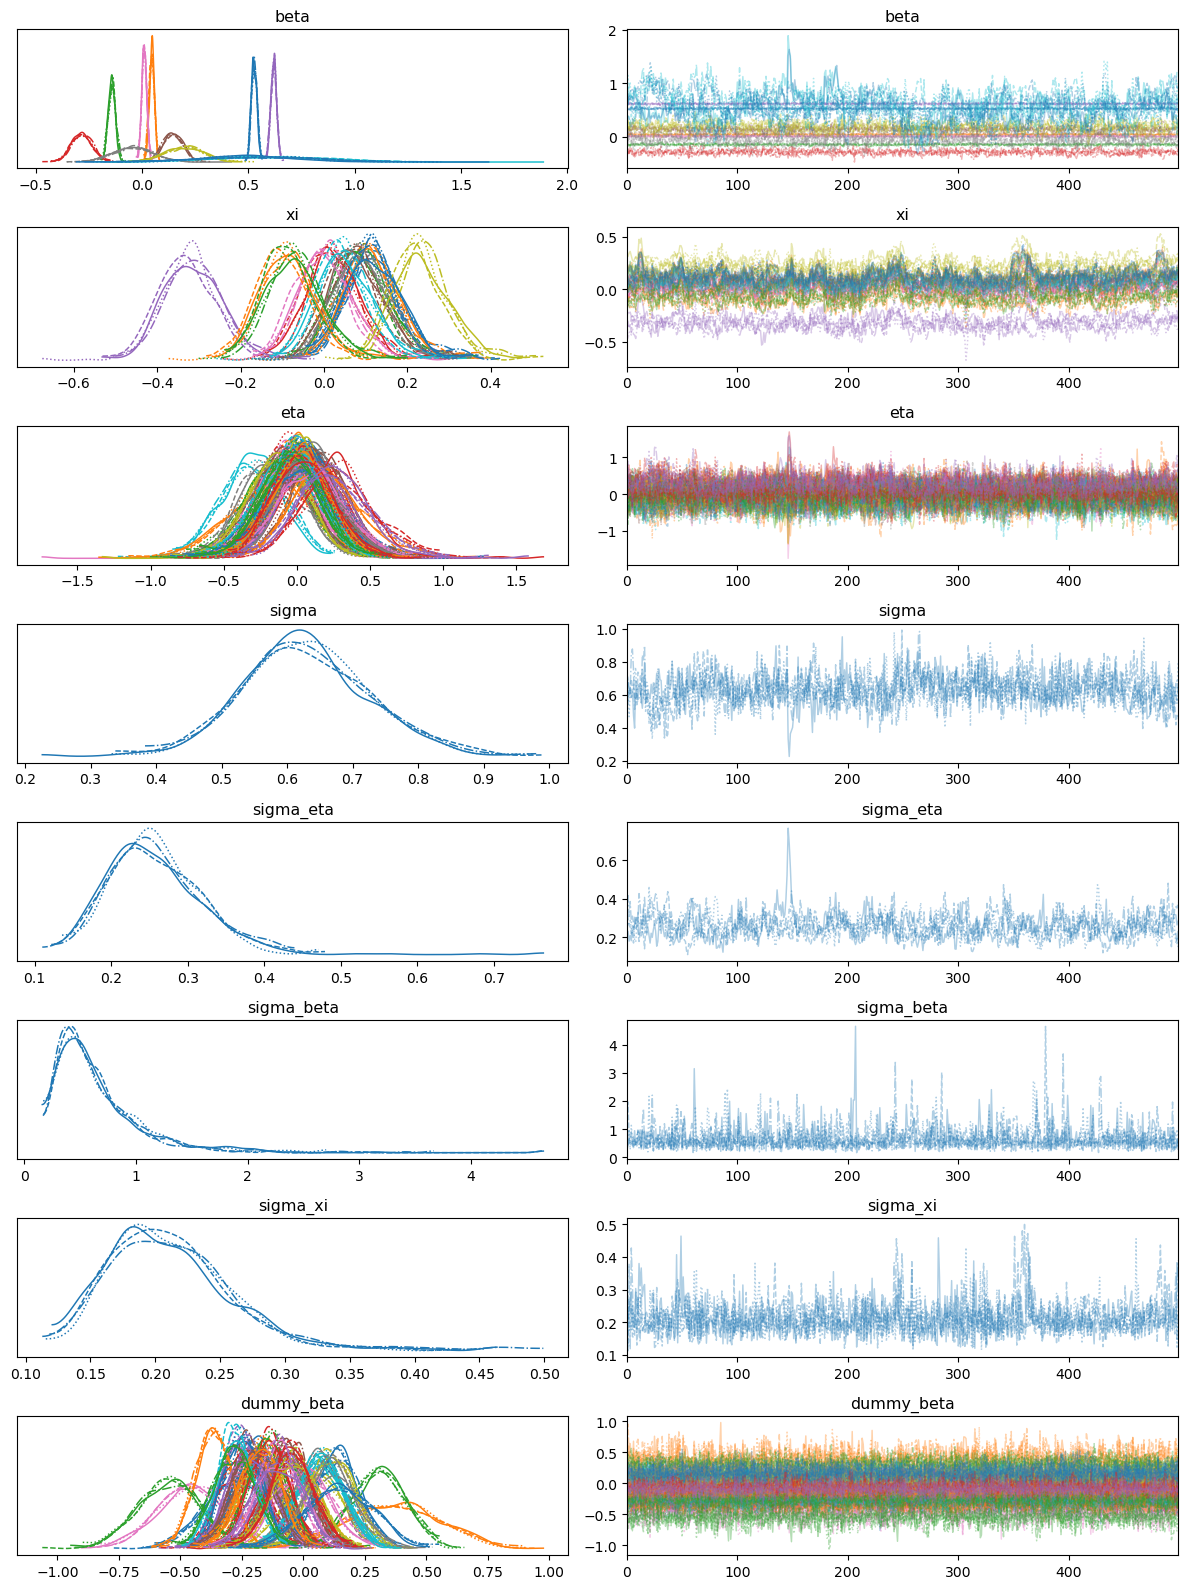

In [38]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'dummy_beta'])
plt.tight_layout()
plt.show()

In [39]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -7019.61    71.94
p_waic      152.87        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -7021.04    71.98
p_loo      154.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2683   99.8%
 (0.5, 0.7]   (ok)          4    0.1%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [40]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [41]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   34   83  145  154  165  173  227  234  309  350  363  385  391
  394  396  404  410  413  414  420  422  429  430  433  472  477  478
  479  481  482  486  488  493  513  526  557  579  581  582  584  585
  588  599  609  618  643  648  650  662  665  669  680  682  685  690
  695  701  702  718  749  753  757  769  770  771  774  775  781  787
  799  802  807  824  835  863  864  869  874  876  877  884  898  901
  917  918  919  920  921  931  950  951  955  961  962  970  984 1009
 1016 1019 1021 1022 1026 1030 1032 1033 1036 1042 1043 1053 1073 1105
 1118 1146 1165 1179 1185 1195 1222 1255 1283 1329 1331 1341 1371 1384
 1385 1407 1408 1409 1449 1521 1527 1535 1540 1552 1559 1563 1591 1611
 1631 1667 1774 1786 1824 1859 1867 1869 1874 1889 1897 1903 1912 1923
 1953 1955 1960 1978 1983 1989 2026 2029 2050 2075 2076 2089 2110 2115
 2119 2127 2134 2137 2140 2144 2160 2180 2198 2214 2221 2227 2228 2234
 2238 2241 2251 2274 2291 2301 2315 2327 2332 2363 2375 2382 2398 2

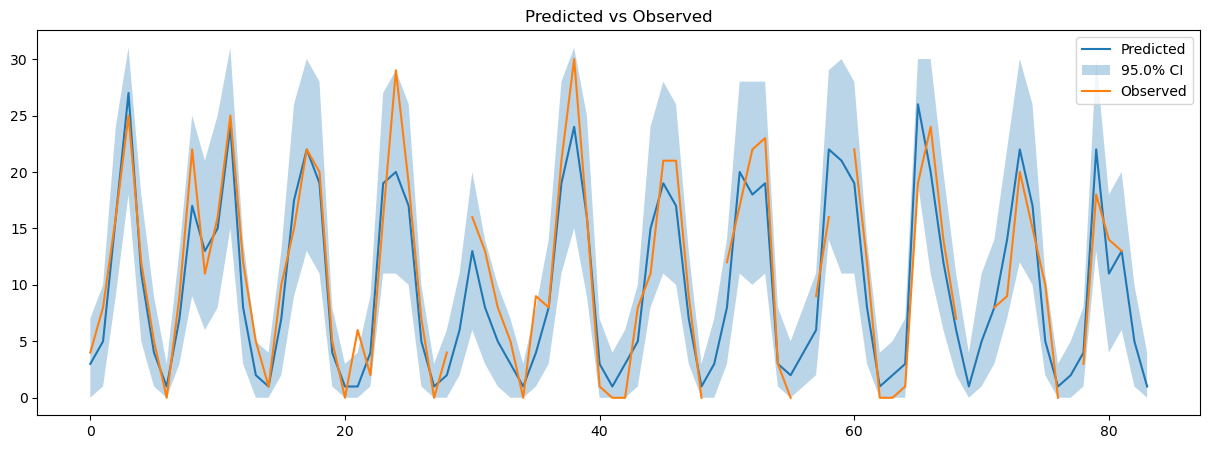

In [48]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()